In [1]:
# Loading images 

# Loading cameras

# Create model 

# Get and batch rays?

# Render -> MSE Loss

# Validation + test


In [ ]:
!pip install ipympl

## Camera parameters estimates

In [2]:
import os
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm, trange


In [3]:
# Log directory
logdir = os.path.join("./", "cache", "log")
os.makedirs(logdir, exist_ok=True)

# Determine device to run on (GPU vs CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Near and far clipping thresholds for depth values.
near_thresh = 2.0
far_thresh = 6.0

"""
Parameters for TinyNeRF training
"""

# Number of functions used in the positional encoding (Be sure to update the
# model if this number changes).
num_encoding_functions = 10
# Specify encoding function.
# encode = positional_encoding
# Number of depth samples along each ray.
depth_samples_per_ray = 32

# Chunksize (Note: this isn't batchsize in the conventional sense. This only
# specifies the number of rays to be queried in one go. Backprop still happens
# only after all rays from the current "bundle" are queried and rendered).
# Use chunksize of about 4096 to fit in ~1.4 GB of GPU memory (when using 8
# samples per ray).
chunksize = 4096

# Optimizer parameters
lr = 5e-3
num_iters = 5000

# Misc parameters
display_every = 100  # Number of iters after which stats are

weightpath = 'weight_smallnerf.tensor'

cuda


In [4]:

"""
Load input images and poses
"""

data = np.load("tiny_nerf_data.npz")

# Images
images = data["images"]
# Camera extrinsics (poses)
tform_cam2world = data["poses"]
tform_cam2world = torch.from_numpy(tform_cam2world).to(device)
# Focal length (intrinsics)
focal_length = data["focal"]
focal_length = torch.from_numpy(focal_length).to(device)

# Height and width of each image
height, width = images.shape[1:3]


# Hold one image out (for test).
# testimg, testpose = images[101], tform_cam2world[101]
# testimg = torch.from_numpy(testimg).to(device)

# # Map images to device
# images = torch.from_numpy(images[:100, ..., :3]).to(device)


In [5]:
print('Images shape: {:}\nPoses shape: {:}\nFocal: {:}'.format(
    data['images'].shape, data['poses'].shape, data['focal']))


Images shape: (106, 100, 100, 3)
Poses shape: (106, 4, 4)
Focal: 138.88887889922103


In [6]:
poses = data['poses']
focal = data['focal']

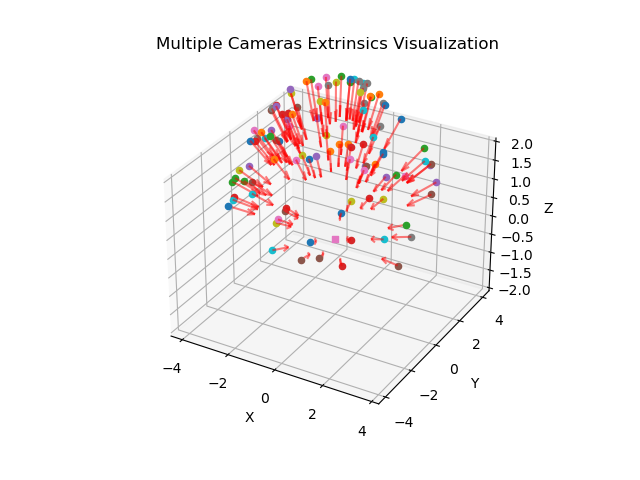

In [9]:
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def visualize_multiple_cameras(camera_extrinsics_list):
    """
    Visualizes the extrinsics of multiple cameras in 3D space.

    Parameters:
    - camera_extrinsics_list (list of numpy.ndarray): List of camera extrinsics matrices (4x4).

    Returns:
    - None
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for camera_extrinsics in camera_extrinsics_list:
        # Extract translation and rotation from camera extrinsics matrix
        translation = camera_extrinsics[:3, 3]
        rotation_matrix = camera_extrinsics[:3, :3]

        # Plot camera position
        ax.scatter(*translation, marker='o')

        # Plot camera orientation axes
        origin = translation
        # for i in range(3):
        #     axis_direction = rotation_matrix[:,i] #* [-1,1,-1][i]
        #     if i == 0:
        #         ax.quiver(*origin, *axis_direction, length=0.5, normalize=True)
        #     else:
        #         ax.quiver(*origin, *axis_direction, length=1, normalize=True)
        ax.quiver(*origin, *-rotation_matrix[:,2], length=1, normalize=True, color='r', alpha=0.5)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Multiple Cameras Extrinsics Visualization')


    # object
    ax.scatter(*[0,0,0], marker='s')

    ax.set_zlim(-2,2)

    plt.show()

# Example usage:
# Replace the following list with your actual list of camera extrinsics matrices

camera_extrinsics_list = poses

visualize_multiple_cameras(camera_extrinsics_list)


In [9]:
# print(poses[0][:3,:3])
# print(poses[0])

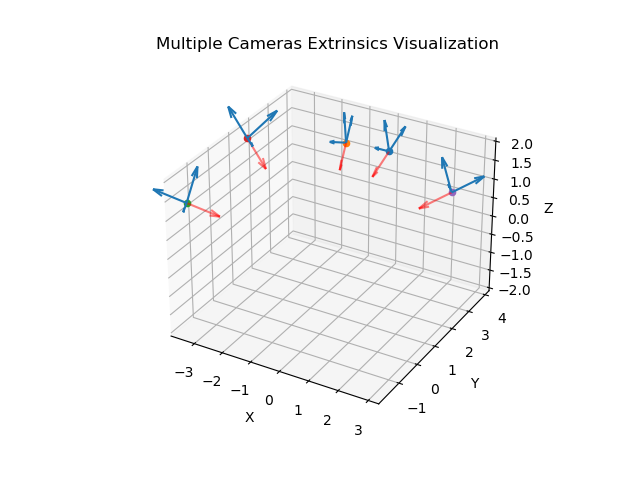

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_cameras(extrinsic_matrices):
    """
    Visualizes the extrinsics of multiple cameras in 3D space.

    Parameters:
    - extrinsic_matrices (numpy.ndarray): Array of camera extrinsics matrices (Nx4x4).
    """
    ax = plt.figure().add_subplot(projection='3d')

    for camera_extrinsics in extrinsic_matrices:
        # Extract translation and rotation from camera extrinsics matrix
        translation = camera_extrinsics[:3, 3]
        rotation_matrix = camera_extrinsics[:3, :3]

        # Plot camera position
        ax.scatter(*translation, marker='o')

        # Plot camera orientation axes
        origin = translation
        for i in range(3):
            axis_direction = rotation_matrix[:,i] #* [-1,1,-1][i]
            if i == 0:
                ax.quiver(*origin, *axis_direction, length=0.5, normalize=True)
            else:
                ax.quiver(*origin, *axis_direction, length=1, normalize=True)
        # Plot camera direction
        z = -1 * rotation_matrix[:,2]
        ax.quiver(*origin, *z, length=1, normalize=True, color='r', alpha=0.5)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Multiple Cameras Extrinsics Visualization')

    ax.set_zlim(-2,2)

    plt.show()


# List of extrinsic matrices or poses
# Example poses all pointing at [0,0,0]
poses = np.array([[
        [-9.9990219e-01,  4.1922452e-03, -1.3345719e-02, -5.3798322e-02],
        [-1.3988681e-02, -2.9965907e-01,  9.5394367e-01,  3.8454704e+00],
        [-4.6566129e-10,  9.5403719e-01,  2.9968831e-01,  1.2080823e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],

       [[-9.3054223e-01,  1.1707554e-01, -3.4696460e-01, -1.3986591e+00],
        [-3.6618456e-01, -2.9751042e-01,  8.8170075e-01,  3.5542498e+00],
        [ 7.4505806e-09,  9.4751304e-01,  3.1971723e-01,  1.2888215e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],

       [[ 4.4296363e-01,  3.1377721e-01, -8.3983749e-01, -3.3854935e+00],
        [-8.9653969e-01,  1.5503149e-01, -4.1494811e-01, -1.6727095e+00],
        [ 0.0000000e+00,  9.3675458e-01,  3.4998694e-01,  1.4108427e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],

       [[ 7.9563183e-01,  5.2092606e-01, -3.0920234e-01, -1.2464346e+00],
        [-6.0578054e-01,  6.8418401e-01, -4.0610620e-01, -1.6370665e+00],
        [-1.4901161e-08,  5.1041979e-01,  8.5992539e-01,  3.4664700e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],

       [[-6.5665424e-01, -2.3678228e-01,  7.1605819e-01,  2.8865230e+00],
        [ 7.5419182e-01, -2.0615987e-01,  6.2345237e-01,  2.5132170e+00],
        [-1.4901163e-08,  9.4943780e-01,  3.1395501e-01,  1.2655932e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]]])

plot_cameras(poses)


In [12]:
# ax = plt.figure().add_subplot(projection='3d')

# for pose in poses:
#     t = pose[:,3][:3]
#     r = pose[:3,:3]
#     cam_world_pos = t #-r.T @ t

#     ax.scatter(*cam_world_pos)


# # ax.scatter(*point0_origin)

In [11]:
# zero_point = np.array([1.,1.,1.])
# camera_center = np.array([1.,1.,1.])

# translations = []
# rotations = []
# for pose in poses:
#     t = pose[:,3][:3]
#     translations += [t]

#     r = zero_point @ pose[:3,:3]
#     rotations += [r]

#     # print(t, r)

# # pp = zero_point

# %matplotlib widget
# ax = plt.figure().add_subplot(projection='3d')
# for i in range(len(poses)):
#     t, r = translations[i],rotations[i]
#     ax.scatter(*t)
#     # ax.plot([t[0],r[0]], [t[1],r[1]], [t[2],r[2]])
# # ax.scatter(*pp, marker='s')


